In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 인셉션 모듈을 만드는 데에 필요한 모듈 불러오기
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model # 모델 시각화

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 2s 0us/step


In [5]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation


In [6]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [8]:
# 문제 1-2. hyperparameter 설정
batch_size = 32
epochs = 10
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [9]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False)

In [11]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
train_data_gen[0][0].shape

(32, 256, 256, 3)

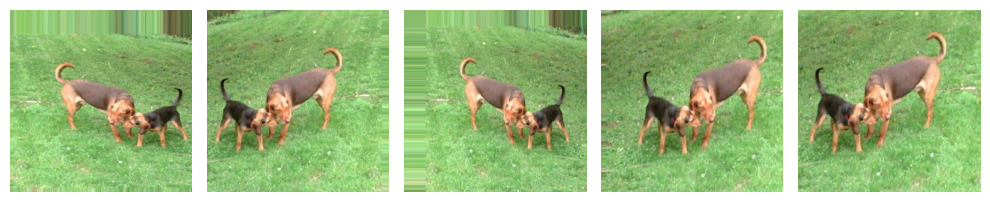

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [14]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [15]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


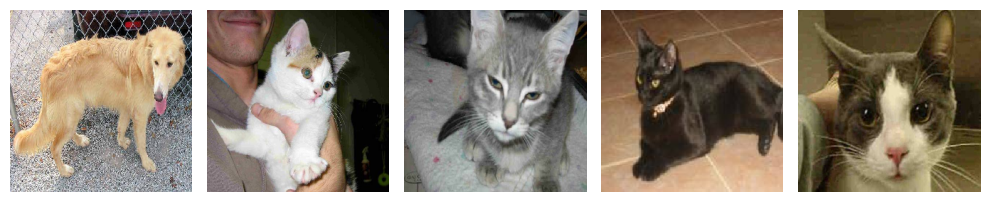

In [16]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [17]:
_[:5] # 정답 데이터

array([1., 0., 0., 0., 0.], dtype=float32)

In [18]:
# 문제 1-2. 모델 구현
# Inception 블록을 만들기 위한 함수
def inception(input_layer, conv1_filter, conv3_in, conv3_out, conv5_in, conv5_out, pooling_out):

    # 1x1 kernel
    conv1 = keras.layers.Conv2D(conv1_filter, (1,1), padding='same', activation='relu')(input_layer)

    # 3x3 kernel
    conv3 = keras.layers.Conv2D(conv3_in, (1,1), padding='same', activation='relu')(input_layer)
    conv3 = keras.layers.Conv2D(conv3_out, (3,3), padding='same', activation='relu')(conv3)

    # 5x5  kernel
    conv5 = keras.layers.Conv2D(conv5_in, (1,1), padding='same', activation='relu')(input_layer)
    conv5 = keras.layers.Conv2D(conv5_out, (5,5), padding='same', activation='relu')(conv5)

    # 3x3 max pooling layer
    pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
    pool = keras.layers.Conv2D(pooling_out, (1,1), padding='same', activation='relu')(pool)

    # 위 4개의 layer 통해서 나온 feature map들을 모두 concatenation 한다.
    #특별히 concatenated_feature_map에 1x1 컨볼루션으로 채널수를 32로 줄였다.
    concatenated_feature_map = keras.layers.Concatenate()([conv1, conv3, conv5, pool])
    concatenated_feature_map = keras.layers.Conv2D(32, (1,1), padding='same', activation='relu')(concatenated_feature_map)
    pooled_feature_map = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(concatenated_feature_map)

    x=tf.keras.layers.Flatten()(pooled_feature_map)
    #x=tf.keras.layers.Dense(4096, activation='relu')(x)
    #x=tf.keras.layers.Dense(4096, activation='relu')(x)
    #x=tf.keras.layers.Dense(1028, activation='relu')(x)
    # x=tf.keras.layers.Dense(512, activation='relu')(x)
    x=tf.keras.layers.Dense(64, activation='relu')(x)
    x=tf.keras.layers.Dense(16, activation='relu')(x)
    out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return out_layer

In [19]:
input_data = keras.layers.Input(shape=(256, 256, 3))
inception_out = inception(input_data, 16, 16, 32, 16, 32, 16)

In [20]:
# 모델 만들기
model = keras.models.Model(inputs=input_data, outputs=inception_out)
# 생성한 모델의 구조 확인하기
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         64        ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 256, 256, 16)         64        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 3)          0         ['input_1[0][0]']             
 D)                                                                                           

In [21]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

#callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [22]:
# 내가 정의한 callback 함수 - checkpoint + early_stopping(기준 : 3)
from tensorflow.keras import callbacks
check_point_cb = callbacks.ModelCheckpoint('MyInception_dog_cat.h5', save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=3, monitor='val_binary_accuracy',
                                  restore_best_weights=True)

In [23]:
# 학습
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      callbacks=[check_point_cb, early_stopping_cb],
      validation_freq=1)

Epoch 1/10
63/62 [==============================] - ETA: 0s - loss: 69.8453 - binary_accuracy: 0.5010

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 76s 1s/step - loss: 69.8453 - binary_accuracy: 0.5010 - val_loss: 0.6936 - val_binary_accuracy: 0.5000
Epoch 2/10
62/62 [==============================] - 53s 858ms/step - loss: 0.6938 - binary_accuracy: 0.4820 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 3/10
62/62 [==============================] - 46s 729ms/step - loss: 0.6938 - binary_accuracy: 0.4900 - val_loss: 0.6932 - val_binary_accuracy: 0.5000
Epoch 4/10
62/62 [==============================] - 56s 898ms/step - loss: 0.6934 - binary_accuracy: 0.5000 - val_loss: 0.6932 - val_binary_accuracy: 0.5000


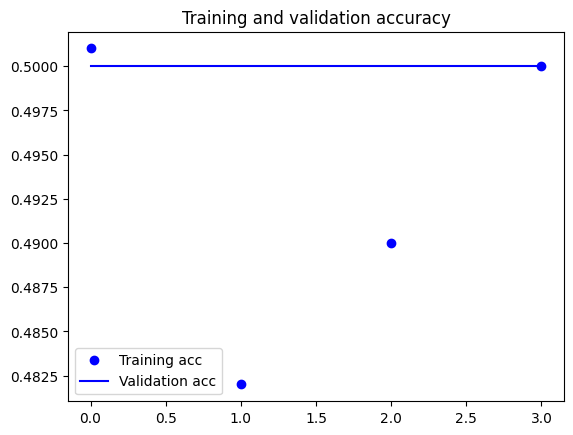

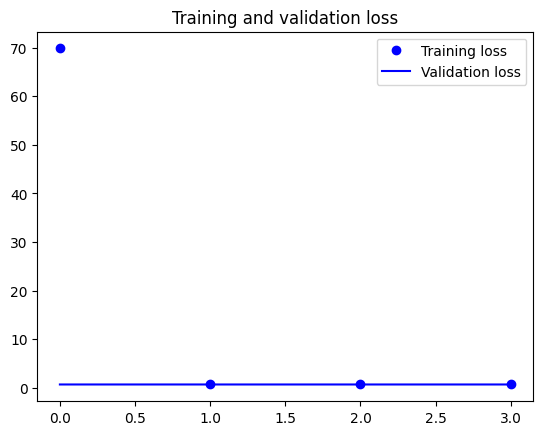

In [24]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()